In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


Dataset sizes:
Training samples: 3133
Validation samples: 349
Number of classes: 10


Starting model training...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2088 - loss: 4.3180
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.2093 - loss: 4.3162 - val_accuracy: 0.0812 - val_loss: 25.7208
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3393 - loss: 3.9004
Epoch 2: val_accuracy improved from 0.08125 to 0.32808, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.3395 - loss: 3.8998 - val_accuracy: 0.3281 - val_loss: 4.6085
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3976 - loss: 3.7306
Epoch 3: val_accuracy improved from 0.32808 to 0.38486, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.3977 - loss: 3.7304 - val_accuracy: 0.3849 - val_loss: 4.0694
Epoch 4/100
97/97 ━━━

<ipython-input-2-a64283f3af16>:299: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


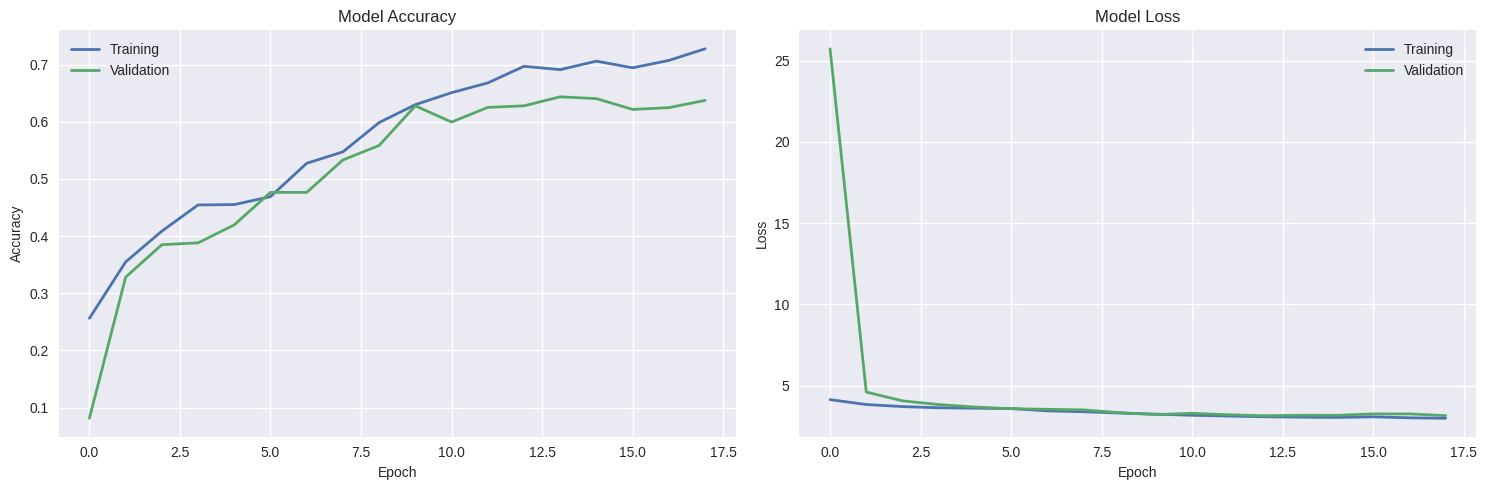

In [2]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enhanced configuration
OPTIMIZED_CONFIG = {
    'data_path': '/kaggle/input/scanned-images-dataset-for-ocr-and-vlm-finetuning/dataset',
    'image_size': (128, 128),
    'batch_size': 32,
    'epochs': 100,
    'initial_learning_rate': 0.0001,
    'num_classes': 10,
    'train_split': 0.9,
    'weight_decay': 0.0001,
    'dropout_rate': 0.4,
    'early_stopping_patience': 5,
    'label_smoothing': 0.1
}

def get_file_paths_and_labels(data_path):
    """Get all image paths and their corresponding labels"""
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels), class_names

def create_data_generators(config):
    """Create separate training and validation generators"""
    
    # Get all file paths and labels
    image_paths, labels, class_names = get_file_paths_and_labels(config['data_path'])
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, 
        labels,
        train_size=config['train_split'],
        stratify=labels,
        random_state=42
    )
    
    # Create generators with data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    def generate_from_paths_and_labels(file_paths, labels, datagen, batch_size, is_training):
        num_samples = len(file_paths)
        num_classes = len(class_names)
        indices = np.arange(num_samples)
        
        while True:
            if is_training:
                np.random.shuffle(indices)
            
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = indices[start:end]
                
                batch_images = np.zeros((len(batch_indices),) + config['image_size'] + (3,))
                batch_labels = np.zeros((len(batch_indices), num_classes))
                
                for idx, sample_idx in enumerate(batch_indices):
                    img_path = file_paths[sample_idx]
                    img = tf.keras.preprocessing.image.load_img(
                        img_path,
                        target_size=config['image_size']
                    )
                    x = tf.keras.preprocessing.image.img_to_array(img)
                    
                    if is_training:
                        x = train_datagen.random_transform(x)
                    x = x / 255.0  # Normalize here instead of using rescale in ImageDataGenerator
                    
                    batch_images[idx] = x
                    batch_labels[idx] = tf.keras.utils.to_categorical(labels[sample_idx], num_classes)
                
                yield batch_images, batch_labels
    
    train_generator = generate_from_paths_and_labels(
        X_train, y_train, train_datagen, config['batch_size'], is_training=True
    )
    
    validation_generator = generate_from_paths_and_labels(
        X_val, y_val, val_datagen, config['batch_size'], is_training=False
    )
    
    return train_generator, validation_generator, len(X_train), len(X_val), len(class_names)

def residual_block(x, filters, kernel_size=3, stride=1, use_bias=True):
    """Custom residual block with advanced regularization"""
    shortcut = x
    
    x = layers.Conv2D(
        filters, kernel_size, 
        strides=stride, 
        padding='same',
        use_bias=use_bias,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(OPTIMIZED_CONFIG['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    x = layers.Conv2D(
        filters, kernel_size,
        padding='same',
        use_bias=use_bias,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(OPTIMIZED_CONFIG['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(
            filters, 1,
            strides=stride,
            padding='same',
            use_bias=use_bias,
            kernel_initializer='he_normal'
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def create_enhanced_model(config):
    """Create a deeper CNN with advanced regularization techniques"""
    inputs = layers.Input(shape=(*config['image_size'], 3))
    
    # Initial processing with GaussianNoise
    x = layers.GaussianNoise(0.1)(inputs)
    
    # Initial convolution
    x = layers.Conv2D(64, 7, strides=2, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # First stack of residual blocks
    for _ in range(3):
        x = residual_block(x, 64)
    
    # Second stack
    x = residual_block(x, 128, stride=2)
    for _ in range(3):
        x = residual_block(x, 128)
    
    # Third stack
    x = residual_block(x, 256, stride=2)
    for _ in range(5):
        x = residual_block(x, 256)
    
    # Fourth stack
    x = residual_block(x, 512, stride=2)
    for _ in range(2):
        x = residual_block(x, 512)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers with regularization
    x = layers.Dense(
        1024,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config['dropout_rate'])(x)
    
    x = layers.Dense(
        512,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config['dropout_rate'])(x)
    
    # Output layer
    outputs = layers.Dense(
        config['num_classes'],
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])
    )(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def main(config):
    """Main training function with advanced techniques"""
    tf.random.set_seed(42)
    np.random.seed(42)
    
    try:
        train_generator, validation_generator, train_samples, val_samples, num_classes = create_data_generators(config)
        
        print(f"\nDataset sizes:")
        print(f"Training samples: {train_samples}")
        print(f"Validation samples: {val_samples}")
        print(f"Number of classes: {num_classes}\n")
        
        steps_per_epoch = max(1, train_samples // config['batch_size'])
        validation_steps = max(1, val_samples // config['batch_size'])
        
        # Create and compile model
        model = create_enhanced_model(config)
        
        # Learning rate schedule
        initial_learning_rate = config['initial_learning_rate']
        lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate,
            first_decay_steps=5 * steps_per_epoch,
            t_mul=2.0,
            m_mul=0.9,
            alpha=0.1
        )
        
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=config['weight_decay'],
            clipnorm=1.0
        )
        
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=config['label_smoothing']),
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath='best_model.keras',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger('training_history.csv')
        ]
        
        # Train the model
        print("\nStarting model training...")
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise

def plot_training_history(history):
    """Plot training metrics"""
    plt.style.use('seaborn')
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    plt.title('Model Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
    plt.title('Model Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        if not os.path.exists(OPTIMIZED_CONFIG['data_path']):
            raise ValueError(f"Data path does not exist: {OPTIMIZED_CONFIG['data_path']}")
        
        model, history = main(OPTIMIZED_CONFIG)
        plot_training_history(history)
        
    except Exception as e:
        print(f"Program failed with error: {str(e)}")

In [5]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enhanced configuration
OPTIMIZED_CONFIG = {
    'data_path': '/kaggle/input/scanned-images-dataset-for-ocr-and-vlm-finetuning/dataset',
    'image_size': (128, 128),
    'batch_size': 32,
    'epochs': 100,
    'initial_learning_rate': 0.001,
    'num_classes': 10,
    'train_split': 0.9,
    'weight_decay': 0.0005,
    'dropout_rate': 0.3,
    'early_stopping_patience': 20,
    'label_smoothing': 0.05
}

def get_file_paths_and_labels(data_path):
    """Get all image paths and their corresponding labels"""
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels), class_names

def create_data_generators(config):
    """Create separate training and validation generators"""
    
    # Get all file paths and labels
    image_paths, labels, class_names = get_file_paths_and_labels(config['data_path'])
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, 
        labels,
        train_size=config['train_split'],
        stratify=labels,
        random_state=42
    )
    
    # Create generators with data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=15,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # shear_range=0.1,
        # zoom_range=0.1,
        # horizontal_flip=True,
        # fill_mode='nearest',
        # brightness_range=[0.9, 1.1]
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    def generate_from_paths_and_labels(file_paths, labels, datagen, batch_size, is_training):
        num_samples = len(file_paths)
        num_classes = len(class_names)
        indices = np.arange(num_samples)
        
        while True:
            if is_training:
                np.random.shuffle(indices)
            
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = indices[start:end]
                
                batch_images = np.zeros((len(batch_indices),) + config['image_size'] + (3,))
                batch_labels = np.zeros((len(batch_indices), num_classes))
                
                for idx, sample_idx in enumerate(batch_indices):
                    img_path = file_paths[sample_idx]
                    img = tf.keras.preprocessing.image.load_img(
                        img_path,
                        target_size=config['image_size']
                    )
                    x = tf.keras.preprocessing.image.img_to_array(img)
                    
                    if is_training:
                        x = train_datagen.random_transform(x)
                    x = x / 255.0
                    
                    batch_images[idx] = x
                    batch_labels[idx] = tf.keras.utils.to_categorical(labels[sample_idx], num_classes)
                
                yield batch_images, batch_labels
    
    train_generator = generate_from_paths_and_labels(
        X_train, y_train, train_datagen, config['batch_size'], is_training=True
    )
    
    validation_generator = generate_from_paths_and_labels(
        X_val, y_val, val_datagen, config['batch_size'], is_training=False
    )
    
    return train_generator, validation_generator, len(X_train), len(X_val), len(class_names)

def residual_block(x, filters, kernel_size=3, stride=1, use_bias=True):
    """Custom residual block with advanced regularization"""
    shortcut = x
    
    x = layers.Conv2D(
        filters, kernel_size, 
        strides=stride, 
        padding='same',
        use_bias=use_bias,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(OPTIMIZED_CONFIG['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    x = layers.Conv2D(
        filters, kernel_size,
        padding='same',
        use_bias=use_bias,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(OPTIMIZED_CONFIG['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(
            filters, 1,
            strides=stride,
            padding='same',
            use_bias=use_bias,
            kernel_initializer='he_normal'
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def create_enhanced_model(config):
    """Create a deeper CNN with advanced regularization techniques"""
    inputs = layers.Input(shape=(*config['image_size'], 3))
    
    # Initial processing with reduced noise
    x = layers.GaussianNoise(0.05)(inputs)
    
    # Initial convolution with smaller kernel
    x = layers.Conv2D(32, 5, strides=2, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, strides=2, padding='same')(x)
    
    # First stack
    for _ in range(2):
        x = residual_block(x, 64)
    
    # Second stack
    x = residual_block(x, 128, stride=2)
    for _ in range(2):
        x = residual_block(x, 128)
    
    # Third stack
    x = residual_block(x, 256, stride=2)
    for _ in range(3):
        x = residual_block(x, 256)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    
    # Single dense layer with reduced complexity
    x = layers.Dense(
        512,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config['dropout_rate'])(x)
    
    # Output layer
    outputs = layers.Dense(
        config['num_classes'],
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])
    )(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def main(config):
    """Main training function with advanced techniques"""
    tf.random.set_seed(42)
    np.random.seed(42)
    
    try:
        train_generator, validation_generator, train_samples, val_samples, num_classes = create_data_generators(config)
        
        print(f"\nDataset sizes:")
        print(f"Training samples: {train_samples}")
        print(f"Validation samples: {val_samples}")
        print(f"Number of classes: {num_classes}\n")
        
        steps_per_epoch = max(1, train_samples // config['batch_size'])
        validation_steps = max(1, val_samples // config['batch_size'])
        
        # Create and compile model
        model = create_enhanced_model(config)
        
        # Learning rate schedule
        initial_learning_rate = config['initial_learning_rate']
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate,
            decay_steps=10 * steps_per_epoch,
            alpha=0.1
        )
        
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=config['weight_decay'],
            clipnorm=1.0,
            epsilon=1e-7
        )
        
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=config['label_smoothing']),
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath='best_model_vol2.keras',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.5,
                patience=5,
                verbose=1,
                min_lr=1e-6
            ),
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger('training_history.csv')
        ]
        
        # Train the model
        print("\nStarting model training...")
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise

def plot_training_history(history):
    """Plot training metrics"""
    plt.style.use('seaborn')
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    plt.title('Model Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
    plt.title('Model Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        if not os.path.exists(OPTIMIZED_CONFIG['data_path']):
            raise ValueError(f"Data path does not exist: {OPTIMIZED_CONFIG['data_path']}")
        
        model, history = main(OPTIMIZED_CONFIG)
        plot_training_history(history)
        
    except Exception as e:
        print(f"Program failed with error: {str(e)}")


Dataset sizes:
Training samples: 3133
Validation samples: 349
Number of classes: 10


Starting model training...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3665 - loss: 5.4827
Epoch 1: val_accuracy improved from -inf to 0.07187, saving model to best_model_vol2.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.3669 - loss: 5.4801 - val_accuracy: 0.0719 - val_loss: 7.5485 - learning_rate: 9.7798e-04
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4917 - loss: 4.3681
Epoch 2: val_accuracy improved from 0.07187 to 0.36278, saving model to best_model_vol2.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4921 - loss: 4.3655 - val_accuracy: 0.3628 - val_loss: 4.4038 - learning_rate: 9.1406e-04
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6002 - loss: 3.4813
Epoch 3: val_accuracy improved from 0.36278 to 0.50158, saving model to best_model_vol2.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6004 - loss: 